In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

from path import Path
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression


In [2]:
# path to dataset
file_path = Path("/Users/Emily/documents/class_data/final_group_airbnb/Resources/cleaned_airbnb_dataset2.csv")
airbnb_df = pd.read_csv(file_path, index_col=0)
airbnb_df.head()

,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total
room_id,,,,,,,,,,,,,,,,,,
958,1169,t,Apartment,Entire home/apt,Western Addition,94117,3,1.0,1.0,1,30,37.76931,-122.43386,217,97.0,170.0,100.0,270.0
3850,4921,t,House,Private room,Inner Sunset,94131,2,1.0,1.0,1,5,37.75402,-122.45805,160,94.0,99.0,10.0,109.0
5858,8904,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.0,1.0,30,60,37.74511,-122.42102,111,98.0,235.0,100.0,335.0
7918,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.0,4.0,32,60,37.76669,-122.45250,18,86.0,65.0,50.0,115.0
8142,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.0,4.0,32,90,37.76487,-122.45183,8,93.0,65.0,50.0,115.0


In [3]:
airbnb_df['zipcode'].isnull().sum

<bound method Series.sum of room_id
958         False
3850        False
5858        False
7918        False
8142        False
            ...  
39337552    False
39342094    False
39343373    False
39344101    False
39350028    False
Name: zipcode, Length: 7816, dtype: bool>

In [4]:
#airbnb_df['bedrooms'].isnull()
#airbnb_df['bathrooms'].isnull().sum()
#airbnb_df['bedrooms'].isnull().sum()
airbnb_df['cleaning_fee'].isnull().sum()

0

In [5]:
airbnb_df['price'].isnull().sum()

0

In [6]:
airbnb_df['total'].isnull().sum()

0

In [7]:
airbnb_df['host_is_superhost'].isnull().sum()

0

In [8]:
airbnb2_df = airbnb_df.drop(['price','cleaning_fee','host_id','latitude','longitude','zipcode'], axis=1)

In [9]:
print(airbnb2_df)

         host_is_superhost property_type        room_type  \
room_id                                                     
958                      t     Apartment  Entire home/apt   
3850                     t         House     Private room   
5858                     f     Apartment  Entire home/apt   
7918                     t     Apartment     Private room   
8142                     t     Apartment     Private room   
...                    ...           ...              ...   
39337552                 f   Guest suite  Entire home/apt   
39342094                 f         House     Private room   
39343373                 f   Condominium  Entire home/apt   
39344101                 f           Hut     Private room   
39350028                 f     Apartment  Entire home/apt   

                   neighborhood  accommodates  bedrooms  bathrooms  \
room_id                                                              
958            Western Addition             3       1.0        1.0

In [10]:
le = LabelEncoder()
airbnb2_df['property_type'] = le.fit_transform(airbnb2_df['property_type'])
airbnb2_df['room_type'] = le.fit_transform(airbnb2_df['room_type'])
airbnb2_df['neighborhood'] = le.fit_transform(airbnb2_df['neighborhood'])
airbnb2_df['host_is_superhost'] = le.fit_transform(airbnb2_df['host_is_superhost'])

In [11]:
file_path = Path("/Users/Emily/documents/class_data/final_group_airbnb/Resources/listings.csv")
original_df = pd.read_csv(file_path, index_col=0)
original_df.head()

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
958,https://www.airbnb.com/rooms/958,2.020000e+13,10/14/2019,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,...,f,f,moderate,f,f,1,1,0,0,1.74
3850,https://www.airbnb.com/rooms/3850,2.020000e+13,10/14/2019,Charming room for two,Your own private room plus access to a shared ...,This room can fit two people. Nobody else will...,Your own private room plus access to a shared ...,none,"This is a quiet, safe neighborhood on a substa...",House Rule footnotes: 1.\tI don’t allow check ...,...,f,f,strict_14_with_grace_period,f,f,3,0,3,0,1.28
5858,https://www.airbnb.com/rooms/5858,2.020000e+13,10/14/2019,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,All the furniture in the house was handmade so...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.87
7918,https://www.airbnb.com/rooms/7918,2.020000e+13,10/14/2019,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",Wi-Fi signal in common areas. Large eat in k...,...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.15
8142,https://www.airbnb.com/rooms/8142,2.020000e+13,10/14/2019,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,NaN,Wi-Fi signal in common areas. Large eat in k...,...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.13


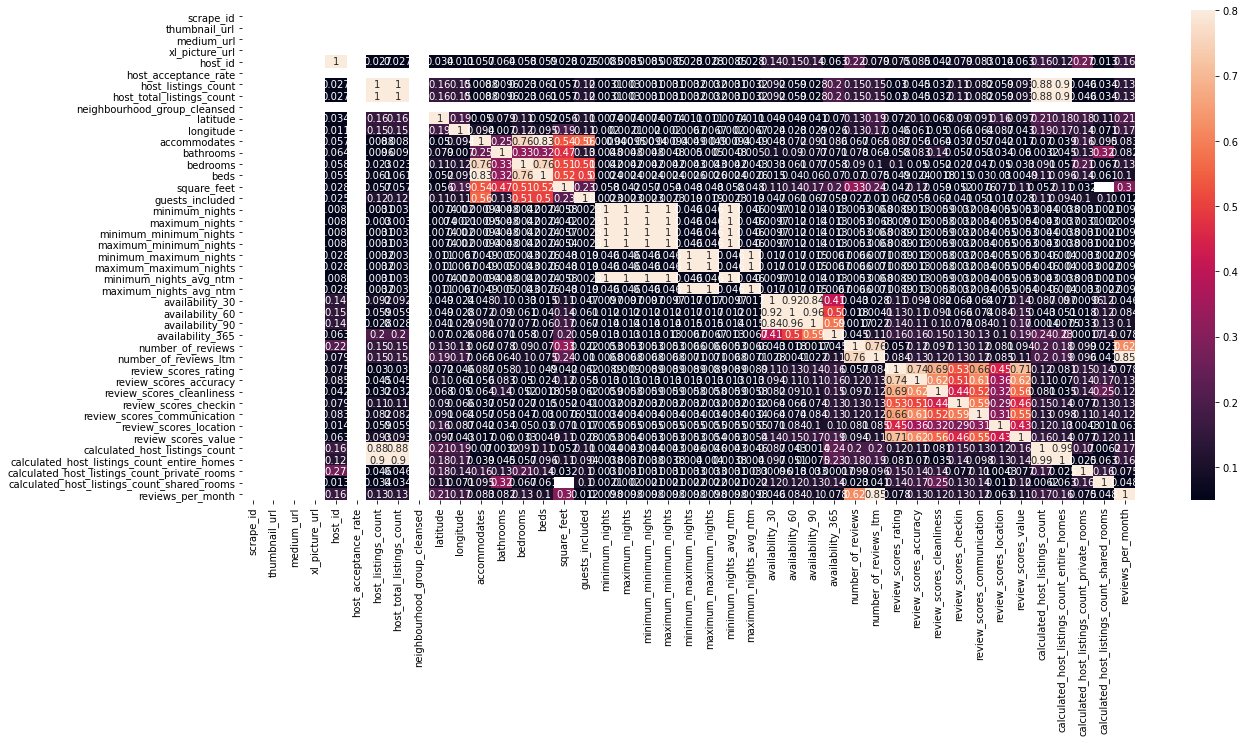

In [12]:
# heatmap
cmx2 = original_df.corr()
cmx2 = abs(cmx2)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(cmx2, vmax=0.8, vmin=0.05, annot=True)

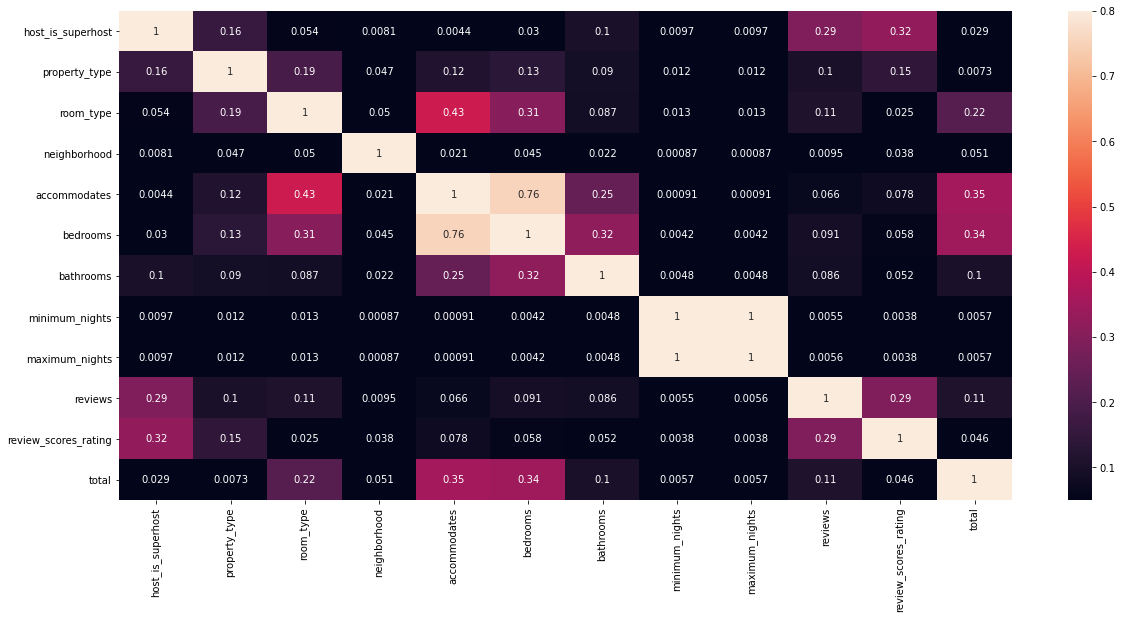

In [13]:
# heatmap
cmx = airbnb2_df.corr()
cmx = abs(cmx)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(cmx, vmax=0.8, vmin=0.05, annot=True)

In [14]:
training_col = ['host_is_superhost','property_type','room_type','neighborhood','accommodates','bedrooms',
           'bathrooms','reviews']
target_col = 'total'

In [15]:
train = np.random.choice([True, False], airbnb2_df.shape[0], replace=True, p=[0.8, 0.2])
airbnb_train = airbnb2_df.iloc[train,:]
airbnb_test = airbnb2_df.iloc[~train,:]

In [16]:
#np.any(np.isnan(airbnb2_df))
#np.all(np.isfinite(airbnb2_df))

In [17]:
x_train = airbnb_train[training_col].values
x_test = airbnb_test[training_col].values
y_train = airbnb_train[target_col].values
y_test = airbnb_test[target_col].values
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6242, 8) (1574, 8) (6242,) (1574,)


In [18]:
airbnb2_df.dtypes

host_is_superhost         int64
property_type             int64
room_type                 int64
neighborhood              int64
accommodates              int64
bedrooms                float64
bathrooms               float64
minimum_nights            int64
maximum_nights            int64
reviews                   int64
review_scores_rating    float64
total                   float64
dtype: object

In [19]:
np.any(np.isnan(airbnb2_df))
np.all(np.isfinite(airbnb2_df))

True

In [20]:
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

In [21]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [22]:
# predict from xtrain
y_pred = lr.predict(x_train)

print("Training Data")
print("R^2 value using score fn: %.3f" % lr.score(x_train,y_train))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
#print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred)))
#print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred))**0.5)

Training Data
R^2 value using score fn: 0.148
Mean Squared Log Error : 162835.920


In [23]:
# predict from xtest
y_pred = lr.predict(x_test)

print("Training Data")
print("R^2 value using score fn: %.3f" % lr.score(x_test,y_test))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))

Training Data
R^2 value using score fn: 0.161
Mean Squared Log Error : 167638.009


In [24]:
print(lr.intercept_, lr.coef_)

146.65176105689548 [  -1.5440619   -15.0793532  -102.22038328   44.41125187  589.28078508
 1200.36398284    4.53386417 -292.08099758]


In [25]:
lr_coef = pd.DataFrame(list(zip(training_col,(lr.coef_))),columns=['Feature','Coefficient'])
lr_coef.sort_values(by='Coefficient',ascending=False)

,Feature,Coefficient
5,bedrooms,1200.363983
4,accommodates,589.280785
3,neighborhood,44.411252
6,bathrooms,4.533864
0,host_is_superhost,-1.544062
1,property_type,-15.079353
2,room_type,-102.220383
7,reviews,-292.080998


In [26]:
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

rf_model = rf_model.fit(x_train, y_train)

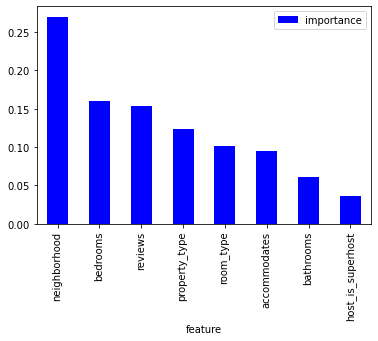

In [27]:
rfr = RandomForestRegressor(max_depth=10, n_estimators=100)
rfr.fit(x_train, y_train)

importances = rfr.feature_importances_
feat_names = training_col
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')

In [28]:
#X = np.array([[airbnb2_df]])

In [29]:
#cmx = confusion_matrix(y_test, y_pred)
#print(cmx)

In [30]:
#cr = classification_report(y_test, y_pred)
#print(cr)